## Segment and modify an image to produce value images

In [1]:
# General imports
import torch
import random
import numpy as np
import os, sys
from datetime import datetime
import matplotlib.pyplot as plt
torch.backends.cudnn.enabled = False

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_lists, write_lists, ensure_dir, list_to_dict, read_json, load_image, informal_log, get_image_id, save_image
from utils.model_utils import prepare_device, quick_predict
from parse_config import ConfigParser
from utils.segmentation_utils import segment_modify_multi_method
from utils.visualizations import show_image_rows, make_grid
from segment import segment_modify_save
import model.model as module_arch

In [42]:
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
target_class = 'dog'
incorrect_images_path = os.path.join('metadata', 'CINIC10-ImageNet', target_class, 'vgg16_bn', 'incorrect_image_paths.txt')
n_select = 20

log_path = 'temp/{}_{}_edit_image/log.txt'.format(n_select, target_class)

seed = 0 # Set to None if want true randomness
debug = True

In [43]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [44]:
### Obtain incorrect images to use for edit
all_incorrect_images = np.array(read_lists(incorrect_images_path))
n_images = len(all_incorrect_images)
np.random.seed(seed)
random.seed(seed)
# key_images = all_incorrect_images[np.random.randint(n_images, size=n_select)]
# TODO: NEED TO TEST
rng = np.random.default_rng(seed)
random_idxs = rng.choice(n_images, size=n_select, replace=False)
assert len(set(random_idxs)) == len(list(random_idxs))

key_images = all_incorrect_images[random_idxs]
print(key_images)


if not debug:
    plt.ioff()


['data/cinic-10-imagenet/train/dog/n02119022_5746.png'
 'data/cinic-10-imagenet/train/dog/n02108254_12208.png'
 'data/cinic-10-imagenet/train/dog/n02104523_8757.png'
 'data/cinic-10-imagenet/train/dog/n02119477_357.png'
 'data/cinic-10-imagenet/train/dog/n02112137_4462.png'
 'data/cinic-10-imagenet/train/dog/n02113799_5574.png'
 'data/cinic-10-imagenet/train/dog/n02113186_5497.png'
 'data/cinic-10-imagenet/train/dog/n02119789_7501.png'
 'data/cinic-10-imagenet/train/dog/n02114367_10155.png'
 'data/cinic-10-imagenet/train/dog/n02114367_2063.png'
 'data/cinic-10-imagenet/train/dog/n02087394_11689.png'
 'data/cinic-10-imagenet/train/dog/n02117135_5376.png'
 'data/cinic-10-imagenet/train/dog/n02114100_7774.png'
 'data/cinic-10-imagenet/train/dog/n01322604_16822.png'
 'data/cinic-10-imagenet/train/dog/n02113023_1337.png'
 'data/cinic-10-imagenet/train/dog/n02084732_56410.png'
 'data/cinic-10-imagenet/train/dog/n02117900_1646.png'
 'data/cinic-10-imagenet/train/dog/n02112018_5329.png'
 'data

## Define variables shared across all images

In [45]:
# Obtain class list
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_to_idx_dict = list_to_dict(class_list)

# General save directories
save_dir_root = os.path.join('saved', 'segmentations', 'semantics', '{}_{}'.format(target_class, n_select))
path_save_dir = os.path.join('paths', 'edits', 'semantics', target_class, timestamp)
ensure_dir(path_save_dir)
# Set parameters for segmentation
felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Set segmentation methods
methods = []
methods.append(('felzenszwalb', felzenszwalb_params))
methods.append(('quickshift', quickshift_params))
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))

In [46]:
# Load config file, and class names file
config_json = read_json(config_path)
config = ConfigParser(config_json, make_dirs=False)
class_names = read_lists(class_list_path)

# Load model and switch to eval mode
layernum = config.config['layernum']
device, _ = prepare_device(config['n_gpu'])
model = config.init_obj('arch', module_arch, layernum=layernum)
model.eval()

CIFAR10PretrainedModelEdit(
  (model): VGG(
    (normalize): InputNormalize()
    (layer0): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer3): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, moment

In [47]:
# function definition
def segment_semantically(image,
            image_id,
            methods_params,
            model,
            device,
            target_idx,
            seed=None,
            save_dir=None,
            plot_absolute=True,
            debug=False):
    
    # Create save paths
    if save_dir is not None:
        ensure_dir(save_dir)
        segmentation_save_path = os.path.join(save_dir, 'segmentations.pth')
        
    else:
        segmentation_save_path = None
        
    # Get logits/softmax of original image
    
    image_logits = quick_predict(model, image, device)
    image_softmax = torch.softmax(image_logits, dim=1)

    if save_dir is not None:
        # image_outputs_save_path = os.path.join(save_dir, 'image_outputs.pth')
        image_save_data = {
            'original_logits': image_logits,
            'original_softmax': image_softmax
        }
        
    segmentation_data = segment_modify_multi_method(
        image=image,
        methods_params=methods_params,
        seed=seed,
        save_path=segmentation_save_path)
    
    if not torch.is_tensor(image):
        image = torch.from_numpy(image).to(device)

    logit_image_save_paths = []
    softmax_image_save_paths = []
    unsuccessful_edit_save_paths = []
    mod_types = ['masked', 'gaussian']
    for seg_idx, (seg_method, _ )in enumerate(methods_params):
        for mod_type in mod_types:
            # Create one save object for logits/softmax
            save_data = { 'image_data': image_save_data }
            
            # Create save directory
            if save_dir is not None:
                local_save_dir = os.path.join(save_dir, "{}_{}".format(seg_method, mod_type))
                ensure_dir(local_save_dir)
                    
            # Obtain modified images 
            modified_images = segmentation_data['{}_modified_images'.format(mod_type)][seg_idx]
            n_images = len(modified_images)
            
            # Pass segments through model
            modified_images = np.stack(modified_images, axis=0)
            modified_images = torch.from_numpy(modified_images).to(device)
            segment_logits = quick_predict(
                model=model,
                image=modified_images,
                device=device, 
                data_format='CHW')
            segment_softmax = torch.softmax(segment_logits, dim=1)
            
            for out_type in ['logits', 'softmax']:
                
                if out_type == 'softmax':
                    segment_out = segment_softmax
                    image_out = image_softmax
                else: 
                    segment_out = segment_logits
                    image_out = image_logits

                # Sort output by target score
                segment_out_target_class = segment_out[:, target_idx]
                sorted_idx = torch.argsort(segment_out_target_class, descending=True)

                # Sort individual segments and model outputs,
                sorted_segments = modified_images[sorted_idx]
                sorted_segment_out = segment_out[sorted_idx]
                sorted_segment_logits = segment_logits[sorted_idx]
                sorted_segment_softmax = segment_softmax[sorted_idx]  
                
                
                
                # Prepend original image and its output score to tensors
                sorted_segments = torch.cat([torch.unsqueeze(image, dim=0), sorted_segments], dim=0)
                sorted_segment_out = torch.cat([image_out, sorted_segment_out], dim=0)
                sorted_segment_logits = torch.cat([image_logits, sorted_segment_logits], dim=0)
                sorted_segment_softmax = torch.cat([image_softmax, sorted_segment_softmax], dim=0)
                
                # if out_type == 'softmax':
                #     sorted_segment_out = sorted_segment_softmax
                # else:
                #     sorted_segment_out = sorted_segment_logits
                
                # Obtain predictions for individual segments
                segment_predictions = torch.argmax(sorted_segment_out, dim=1)
                segment_prediction_strings = [class_list[pred] for pred in segment_predictions]
                
                # Isolate output (logits/softmax) for the target idx
                segment_target_out = sorted_segment_out[:, target_idx]

                # Accumulate sorted segments
                accumulation_image = torch.clone(image)
                cumulative_images = []
                for image_segment in sorted_segments:
                    # Isolate segment and add to accumulation_image
                    segment = torch.where(image_segment != image, 1, 0)
                    accumulation_image = torch.where(segment == 1, image_segment, accumulation_image)
                    
                    # convert to numpy and Add to list
                    cumulative_images.append(accumulation_image)

                    
                # Stack and convert to torch
                cumulative_images = torch.stack(cumulative_images, dim=0)
                
                # Pass through model
                cumulative_logits = quick_predict(
                    model=model,
                    image=cumulative_images,
                    device=device,
                    data_format='CHW')
                cumulative_softmax = torch.softmax(cumulative_logits, dim=1)
                if out_type == 'softmax':
                    cumulative_out = cumulative_softmax
                else: 
                    cumulative_out = cumulative_logits
                
                # Get predictions for all cumulative images
                cum_predictions = torch.argmax(cumulative_out, dim=1)
                cum_prediction_strings = [class_list[pred] for pred in cum_predictions]
                    
                # For cumulative images, get logits/softmax at target_idx
                cum_target_out = cumulative_out[:, target_idx]  # B x 1
                
                # Get delta from original image logits/softmax
                cum_delta_target_out = cum_target_out - image_out[:, target_idx] # B x 1
                segment_delta_target_out = segment_target_out - image_out[:, target_idx] # B x 1

                # Find cumulative image index with highest positive change in target_idx
                out_argmax = torch.argmax(cum_target_out) # 1 val

                # Obtain corresponding image
                most_change_image = cumulative_images[out_argmax]
                
                # Obtain final prediction for this image
                most_change_image_out = cumulative_out[out_argmax]  # 1 x 10
                most_change_image_prediction = torch.argmax(most_change_image_out)
                
                
                '''
                Display and save
                '''
                # Display segments by ranking and accumulation_image
                segment_labels = []
                cum_labels =  [] 
                segment_borders = []
                cum_borders = []
                '''
                Define local function definition
                '''
                def create_borders_labels(inputs,
                                          predictions,
                                          logits,
                                          softmax,
                                          labels_arr, 
                                          borders_arr):
                    for image_idx in range(len(inputs)):
                        # Create labels for each image in row
                        labels_arr.append("N: {}\nTrue: {}\nPred: {}\n[L: {}/S: {}]".format(
                            image_idx,
                            class_list[target_idx], 
                            class_list[predictions[image_idx]],
                            round(logits[image_idx, target_idx].item(), 2),
                            round(softmax[image_idx, target_idx].item(), 2)))

                        # Create borders
                        if predictions[image_idx] == target_idx:
                            borders_arr.append('green')
                        else:
                            borders_arr.append('red')
                '''
                End local function definition
                '''
                # Top row is segments, bottom row is cumulative images
                for data_type in ['segment', 'cumulative']:
                    if data_type == 'segment':
                        create_borders_labels(
                            inputs=sorted_segments,
                            predictions=segment_predictions,
                            logits=sorted_segment_logits,
                            softmax=sorted_segment_softmax,
                            labels_arr=segment_labels,
                            borders_arr=segment_borders)
                    else:
                        create_borders_labels(
                            inputs=cumulative_images,
                            predictions=cum_predictions,
                            logits=cumulative_logits,
                            softmax=cumulative_softmax,
                            labels_arr=cum_labels,
                            borders_arr=cum_borders)
                
                # Create grid for visualization
                fig, axs = show_image_rows(
                    images=[sorted_segments.cpu().numpy(), cumulative_images.cpu().numpy()],
                    image_titles=[segment_labels, cum_labels],
                    image_borders=[segment_borders, cum_borders], 
                    row_labels=['Indvidual Segments', 'Cumulative Image'],
                    figure_title='Sorted by {} scores for {} class ({}) [{}/{}]'.format(out_type, class_list[target_idx], image_id, seg_method, mod_type),
                    subplot_padding=2,
                    save_path=None,
                    show_figure=False)
                
                # Bold the selected image (if applicable)
                if most_change_image_prediction == target_idx:
                    plt.setp(axs[1][out_argmax].spines.values(), color='yellow', linewidth=5.0)
                    
                # Save figure
                if save_dir is not None:
                    plt.savefig(os.path.join(local_save_dir, '{}_cumulative_modifying.png'.format(out_type)))
                if debug:
                    plt.show()
                # Add to save_data
                save_data.update({
                    '{}_sorted_segments'.format(out_type): sorted_segments,
                    '{}_cum_modifications'.format(out_type): cumulative_images, # B x C x H x W torch.tensor
                    '{}_segment_out'.format(out_type): sorted_segment_out.cpu().numpy(), # B x 10 np.array
                    '{}_cum_out'.format(out_type): cumulative_out.cpu().numpy(), # B x 10 np.array
                    '{}_most_change_image'.format(out_type): most_change_image.cpu().numpy() # C x H x W np.array
                })

                if save_dir is not None:
                    # Save plots
                    plot_save_path = os.path.join(local_save_dir, 'target_{}_v_n_images.png')
                   
                    if not plot_absolute:  # plot changes
                        ylabel = 'Change in {} Score for {} class'.format(out_type, class_list[target_idx])
                        
                        ys = [cum_delta_target_out.cpu().numpy(), 
                              segment_delta_target_out.cpu().numpy()]
                        
                    else:  
                        ylabel = '{} Score for {} class'.format(out_type, class_list[target_idx])
                        ys = [cum_target_out.cpu().numpy(), 
                              segment_target_out.cpu().numpy()]
                    
                    # Set non-y-related values
                    xlabel = 'Number of Segments Modified'
                    xs = [range(n_images+1) for i in range(2)]
                    title = '{} vs {}'.format(ylabel, xlabel)
                    labels = ['Cumulative segments', 'Individual segments']
                    # Mark on graph which is the most changed
                    if most_change_image_prediction == target_idx:
                        highlight = (out_argmax.cpu().numpy(), torch.max(most_change_image_out).cpu().numpy())
                        highlight_label = 'Selected Image'
                    else:
                        highlight = None
                        highlight_label = None
                    plot(
                        xs=xs,
                        ys=ys,
                        labels=labels,
                        scatter=True,
                        line=[True, False],
                        title=title.format(out_type),
                        xlabel=xlabel,
                        ylabel=ylabel.format(out_type),
                        highlight=highlight,
                        highlight_label=highlight_label,
                        save_path=plot_save_path.format(out_type),
                        show=debug)
                    
                    # Save images
                    image_save_path = os.path.join(local_save_dir, '{}_{}_{}.png'.format(seg_method, mod_type, out_type))
                    save_image(
                        most_change_image.cpu().numpy(), 
                        image_save_path)
                    
                    if most_change_image_prediction == target_idx:
                        if out_type == 'softmax':
                            softmax_image_save_paths.append(image_save_path)
                        else:
                            logit_image_save_paths.append(image_save_path)
                    else:
                        unsuccessful_edit_save_paths.append(image_save_path)

            if save_dir is not None:
                # Save torch data
                torch_save_path = os.path.join(local_save_dir, 'cumulative_segment_results.pth')
                torch.save(save_data, torch_save_path)
                
                    
    return logit_image_save_paths, softmax_image_save_paths, unsuccessful_edit_save_paths
        

In [48]:
# move to visualizations.py
def plot(xs,
         ys,
         labels=None,
         title=None,
         xlabel=None,
         ylabel=None,
         scatter=True,
         line=True,
         highlight=None,
         highlight_label=None,
         save_path=None,
         show=False):
    '''
    
    Arg(s):
        xs : list[list[float]]
            x values
        ys : list[list[float]]
            y values
        title : str
            title of plot
        xlabel : str
            x-axis label
        ylabel : str
            y-axis label
        scatter : bool or list[bool]
            denoting if should show each data point or not
        line : bool or list[bool]
            denoting if should connect lines or not
        highlight : (list[float], list[float])
            tuple of data point(s) to accentuate
        save_path : str
            path to save graph to
        show : bool
            whether or not to display graph
        
    '''
    plt.clf()
    n_lines = len(xs)
    if labels is None:
        labels = [None for i in range(n_lines)]
        
    assert len(ys) == n_lines, "ys list must be same length as xs. Received {} and {}".format(len(ys), n_lines)
    assert len(labels) == n_lines, "Labels list must be same length as xs. Received {} and {}".format(len(labels), n_lines)
    
    if type(scatter) == bool:
        scatter = [scatter for i in range(n_lines)]
    else: 
        len(scatter) == n_lines, "scatter list must be same length as xs. Received {} and {}".format(len(scatter), n_lines)
    if type(line) == bool:
        line = [line for i in range(n_lines)]
    else: 
        len(line) == n_lines, "line list must be same length as xs. Received {} and {}".format(len(line), n_lines)
    if highlight is not None:
        highlight_x, highlight_y = highlight
        format_str = 'ys'
        marker_size = 10
        zorder = 3
        if highlight_label is not None:
            plt.plot(
                highlight_x, 
                highlight_y, 
                format_str, 
                markersize=marker_size, 
                zorder=zorder, 
                label=highlight_label)
        else:
            plt.plot(
                highlight_x, 
                highlight_y, 
                format_str, 
                markersize=marker_size,
                zorder=zorder)
    for idx in range(n_lines): #x, y, label in zip(xs, ys, labels):
        x = xs[idx]
        y = ys[idx]
        label = labels[idx]
        
        format_str = 'o'
        if scatter[idx] and line[idx]:
            format_str = '-o'
        elif not scatter[idx] and line[idx]:
            format_str = '-'
        
        if label is not None:
            plt.plot(x, y, format_str, zorder=1, label=label)
        else:
            plt.plot(x, y, format_str, zorder=1)
    
        
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if labels[0] is not None:
        plt.legend()
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if debug:
        plt.show()

data/cinic-10-imagenet/train/dog/n02119022_5746.png
Target idx: 5
Image save directory: saved/segmentations/semantics/dog_20/dog-train-n02119022_5746


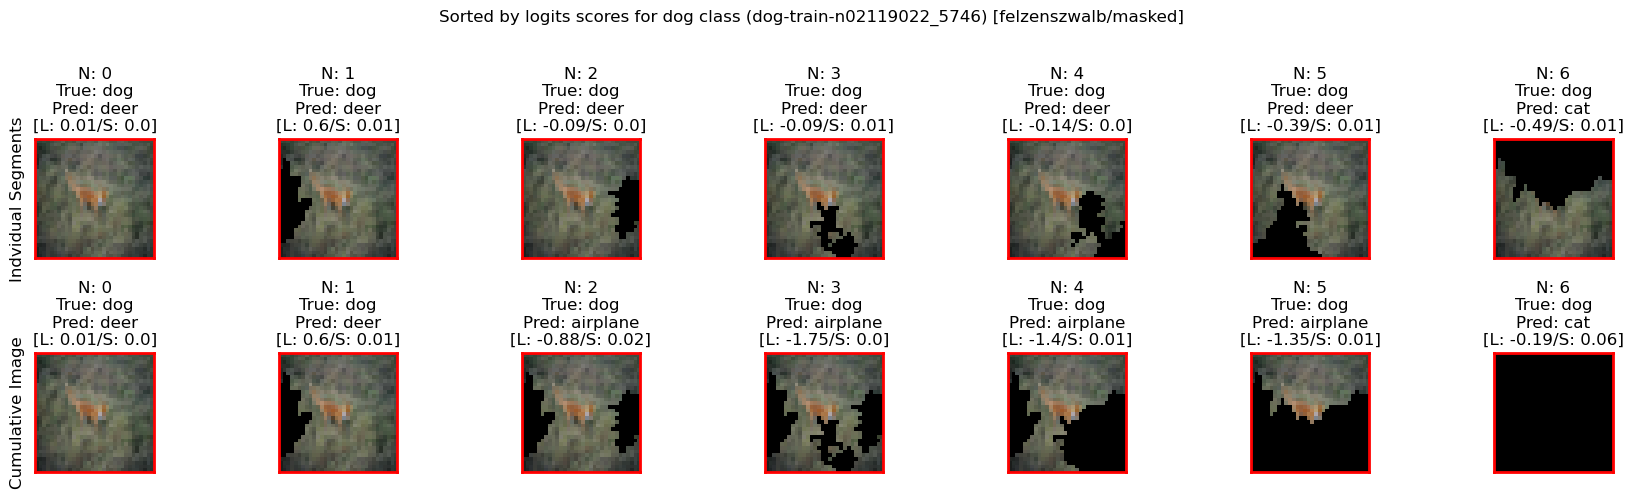

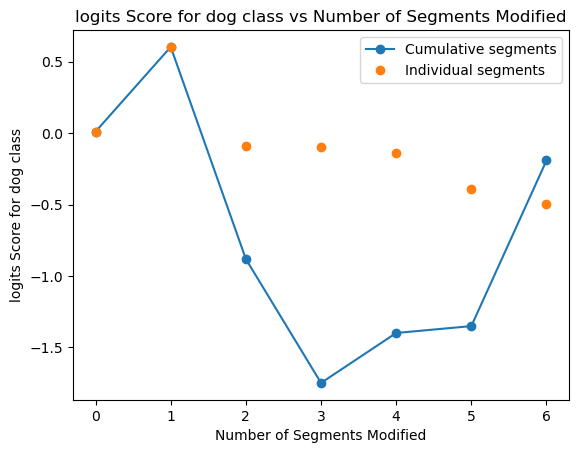

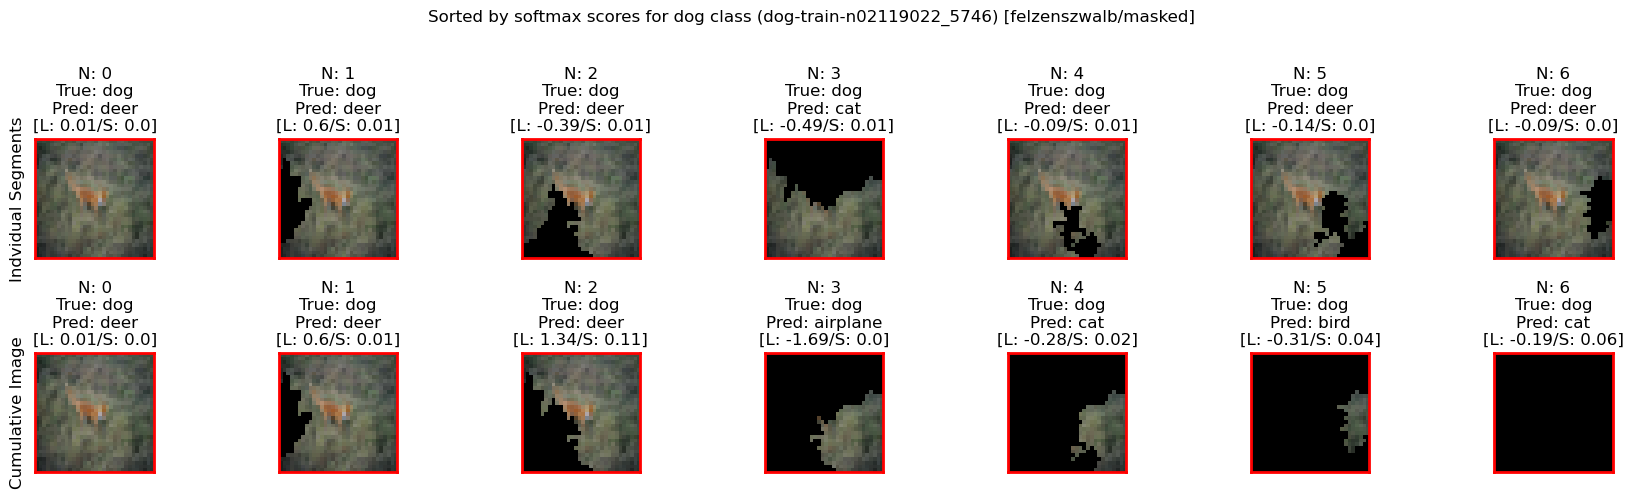

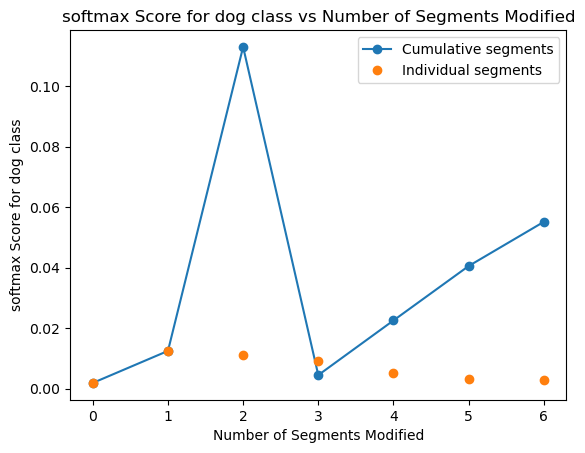

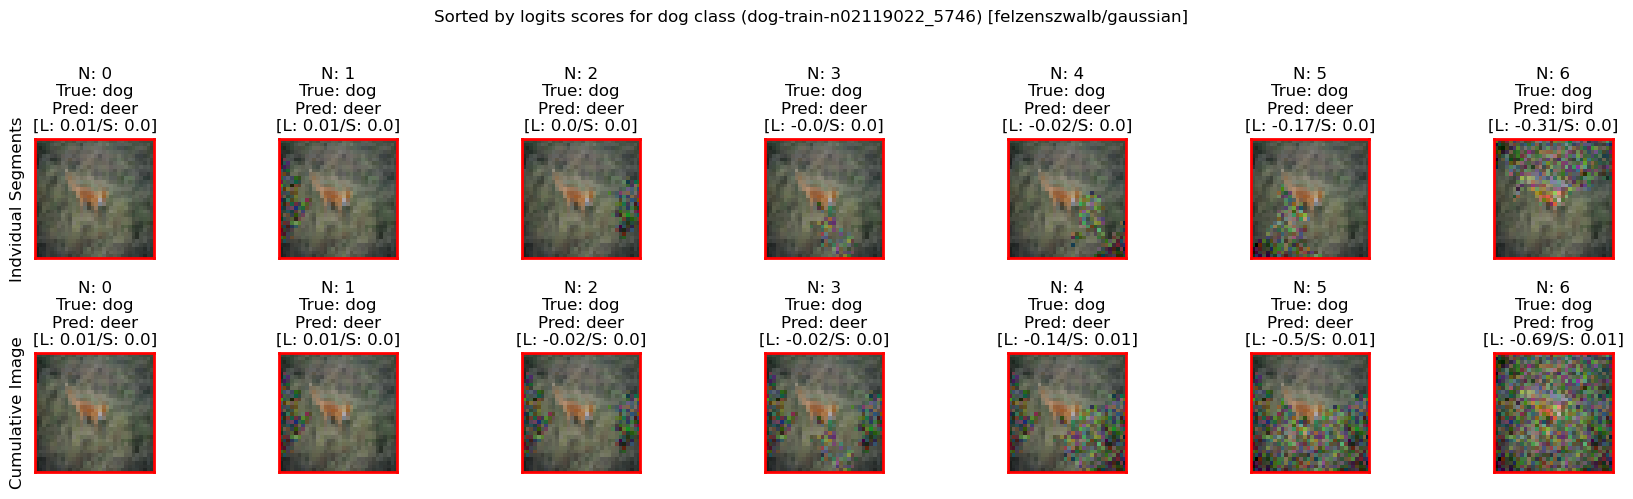

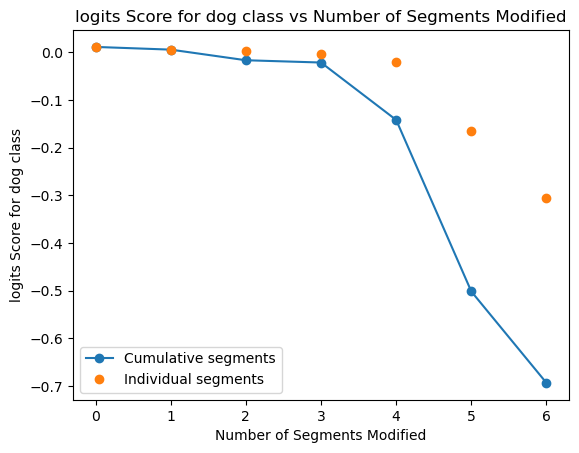

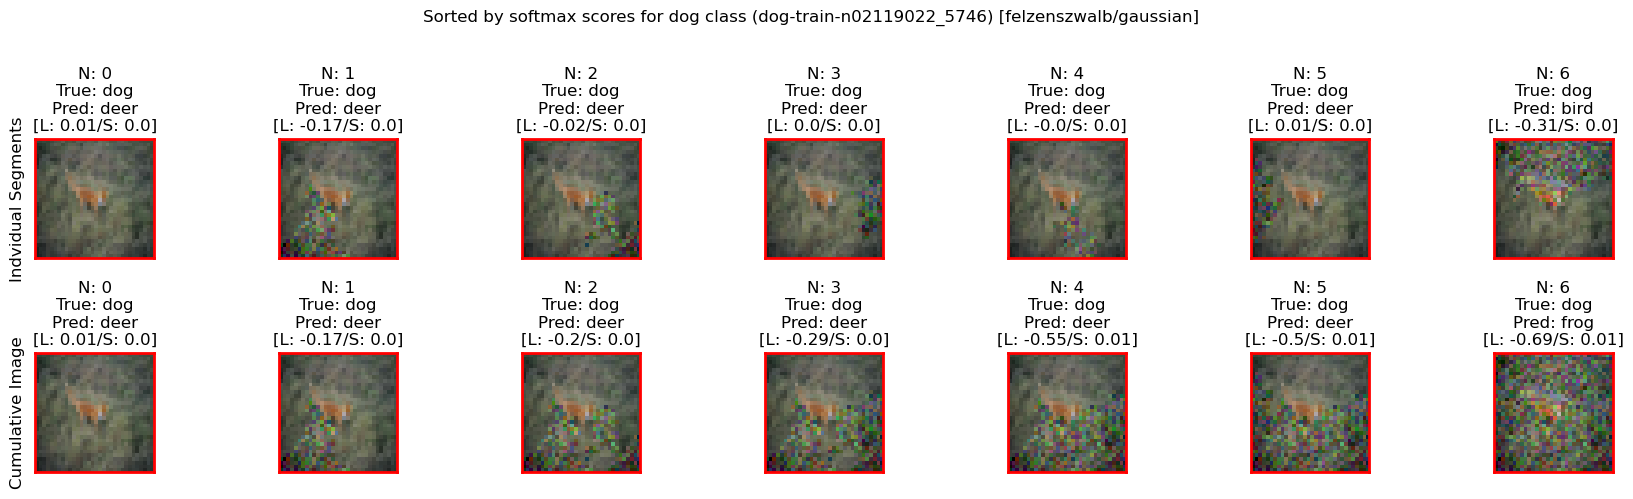

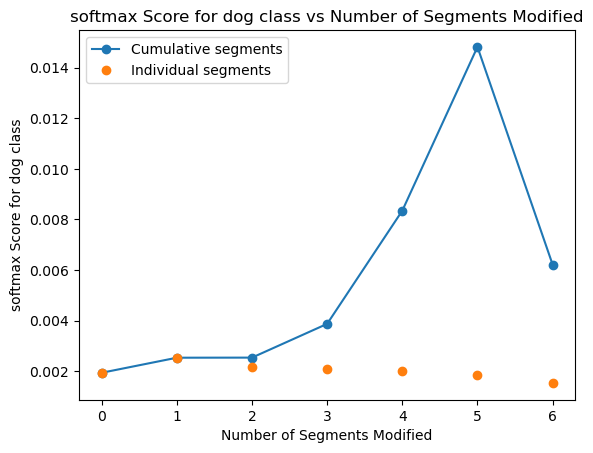

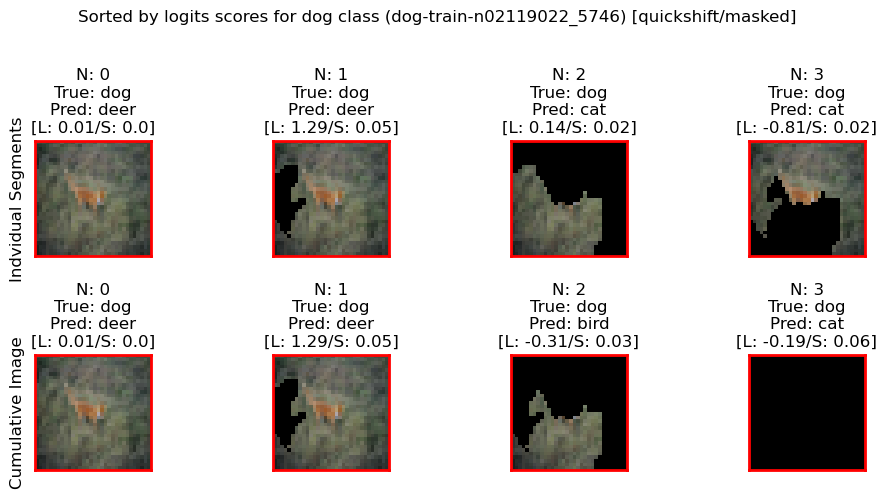

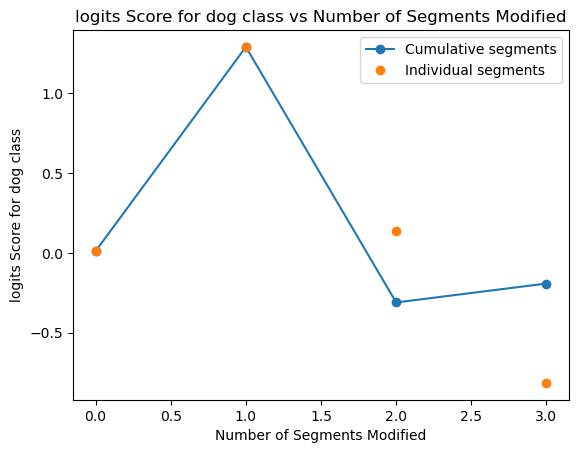

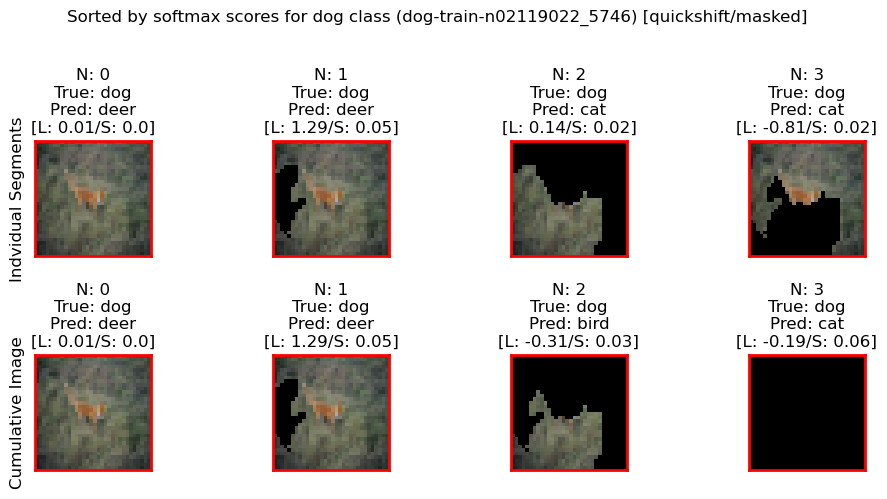

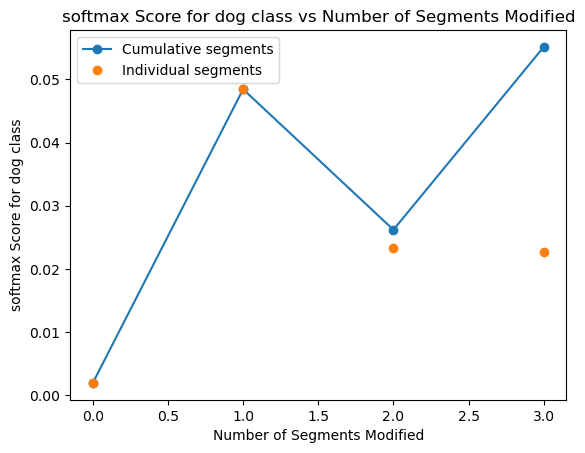

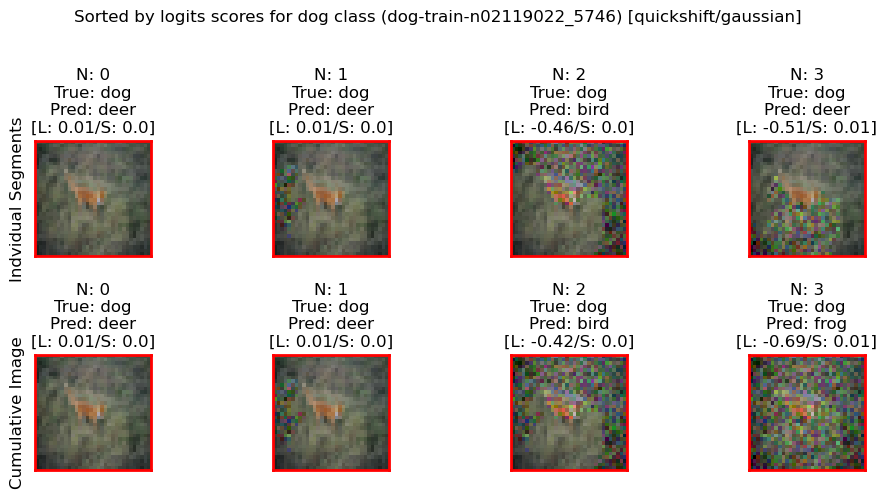

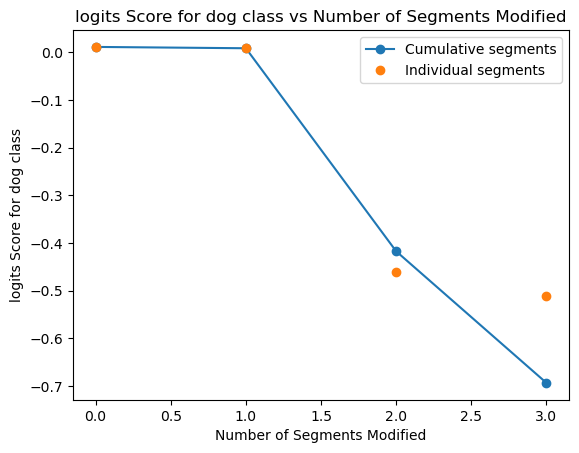

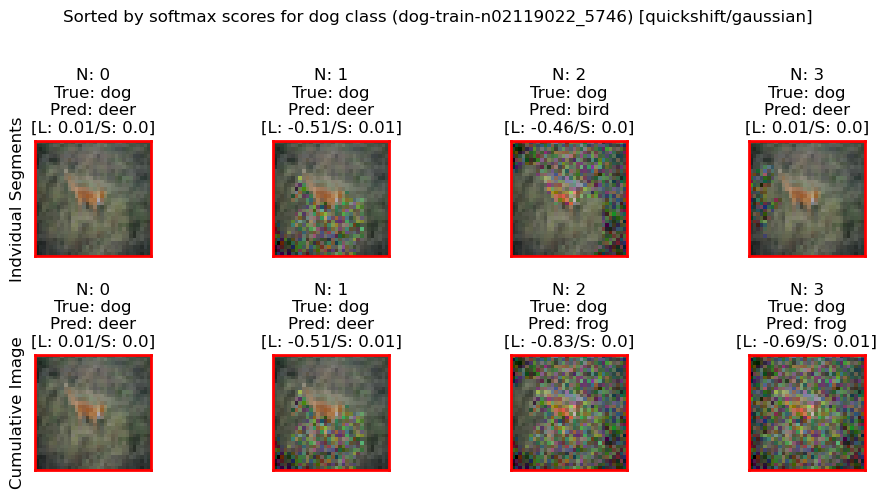

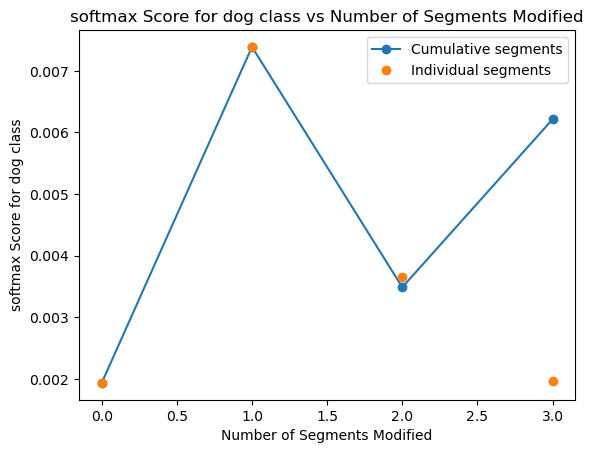

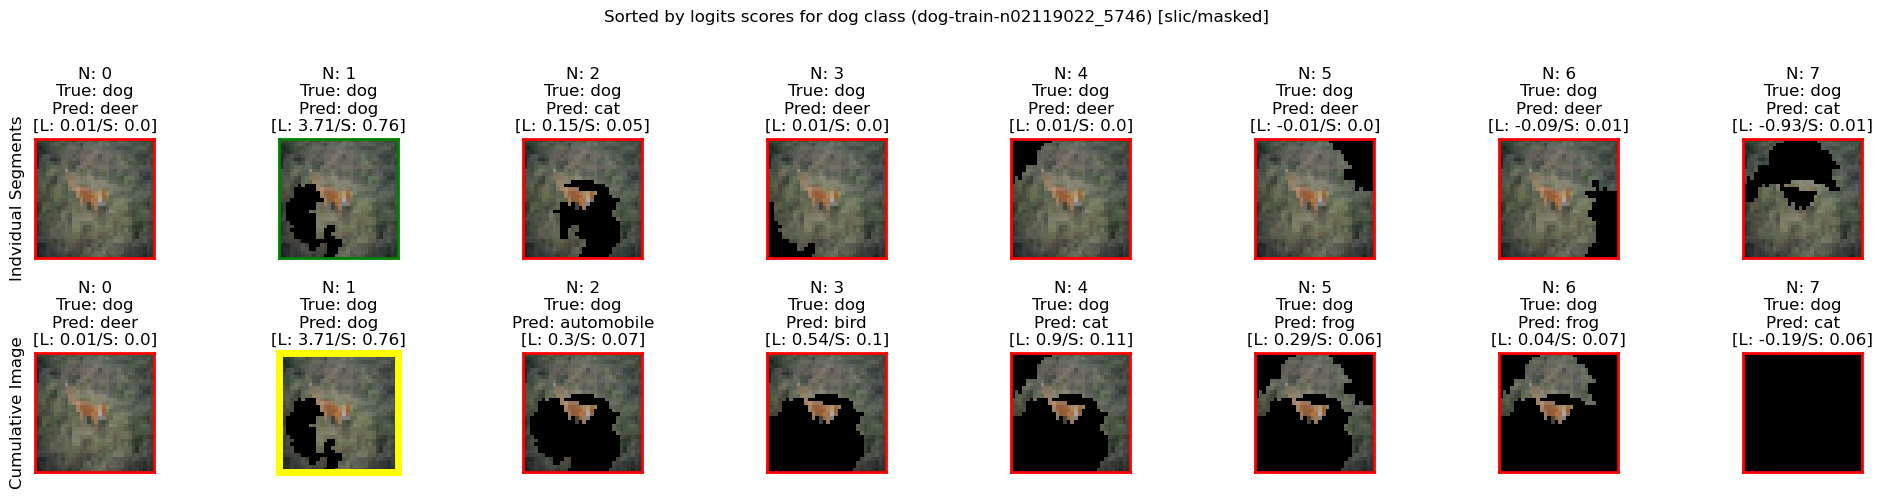

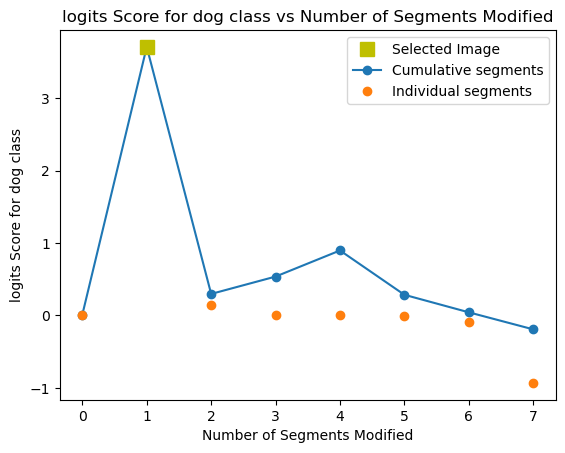

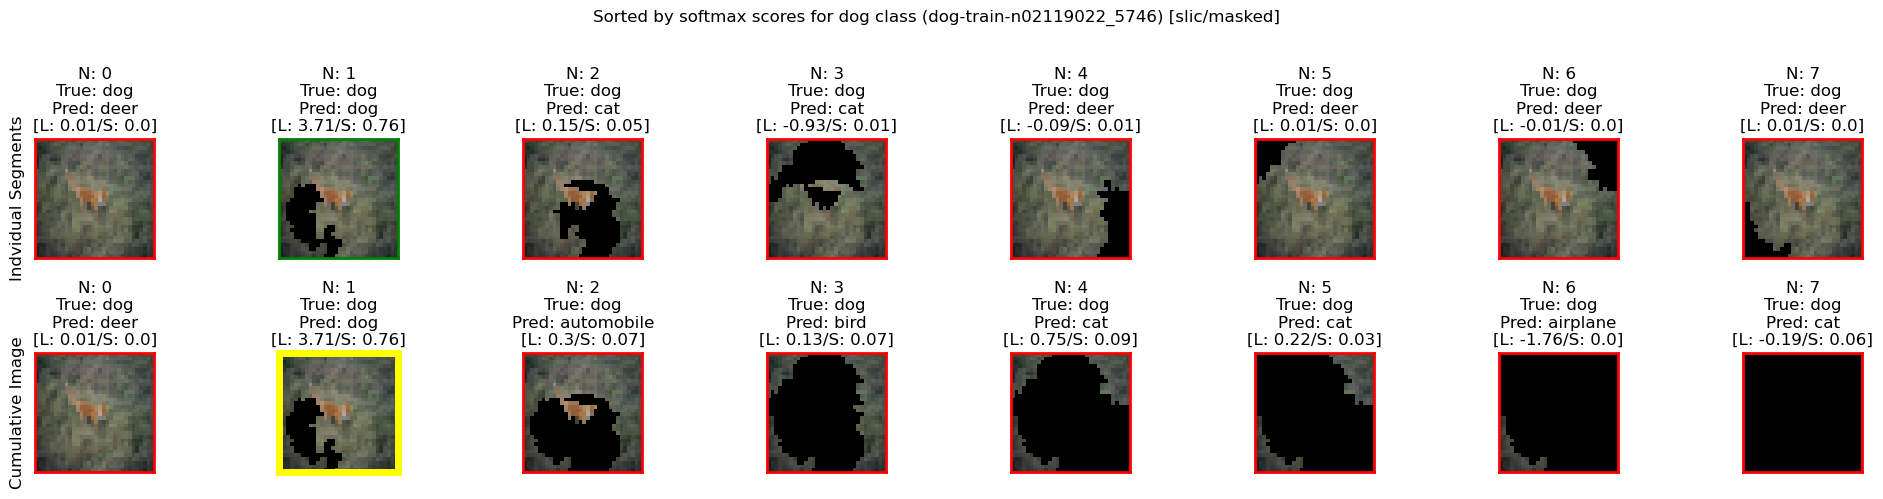

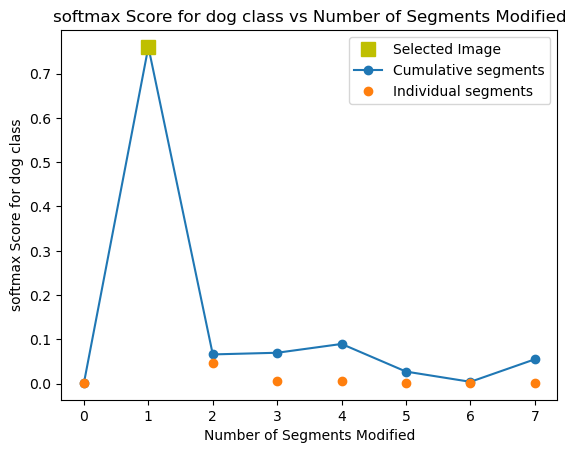

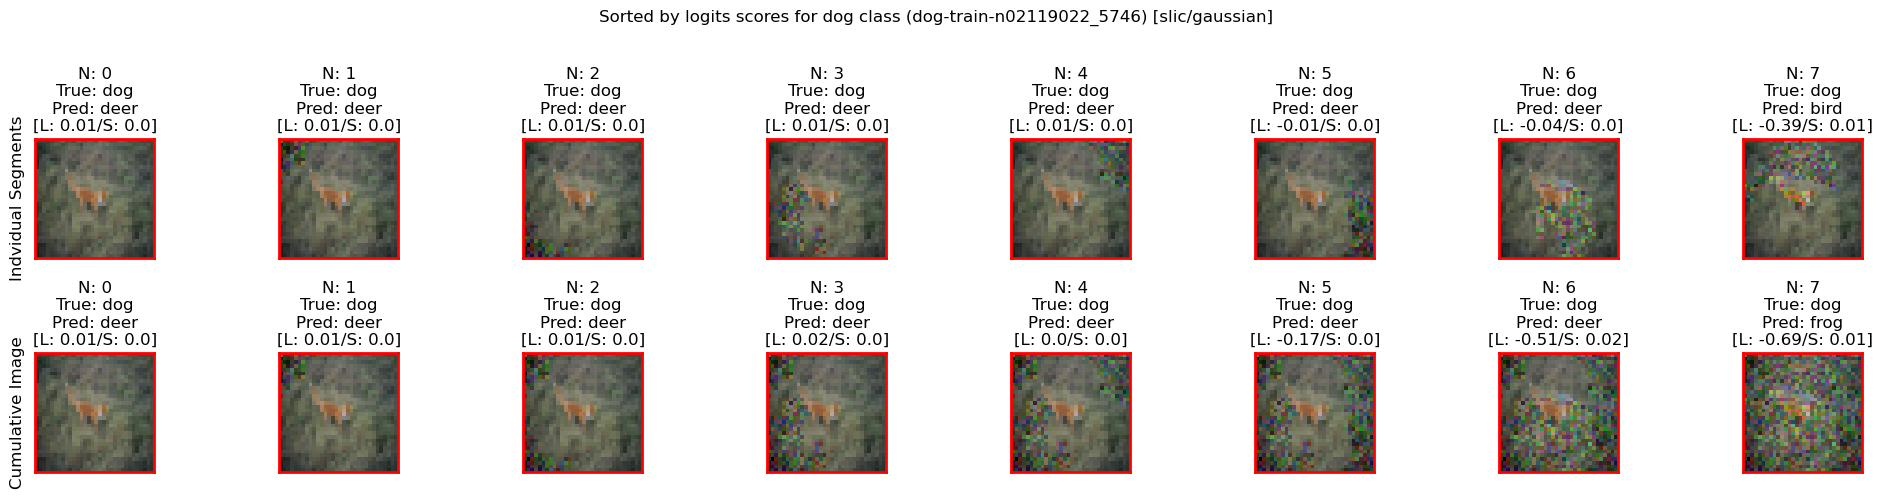

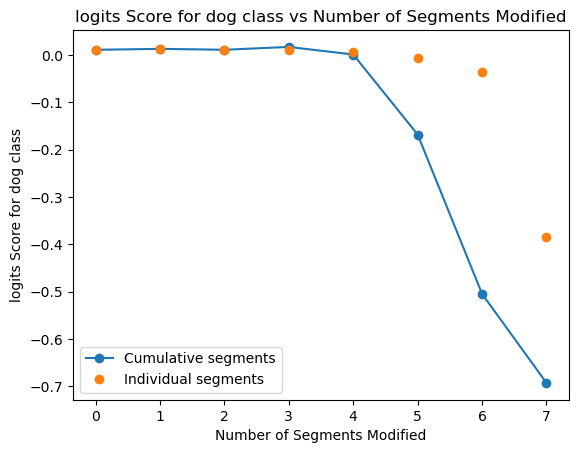

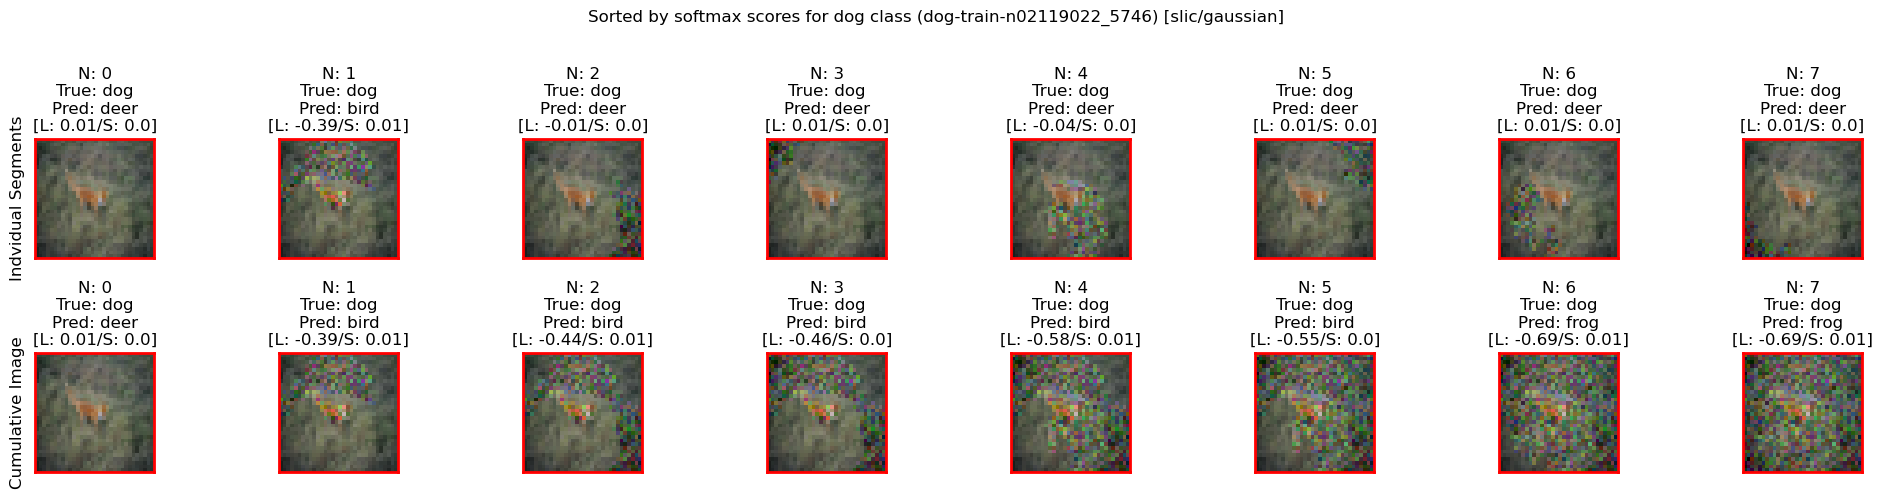

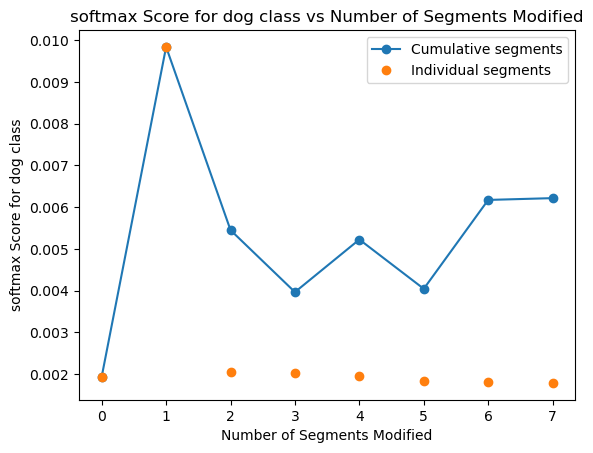

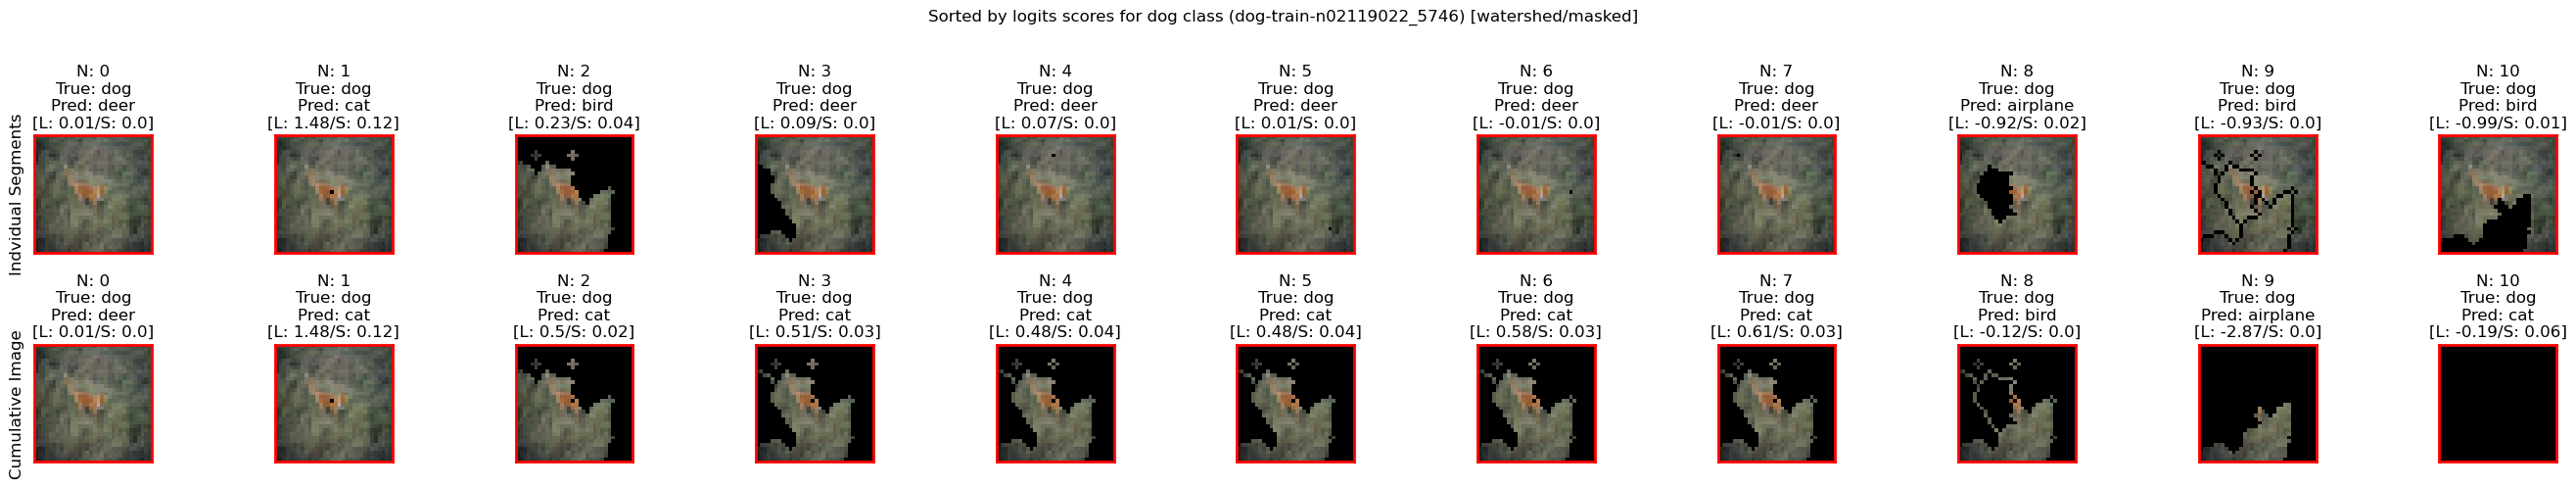

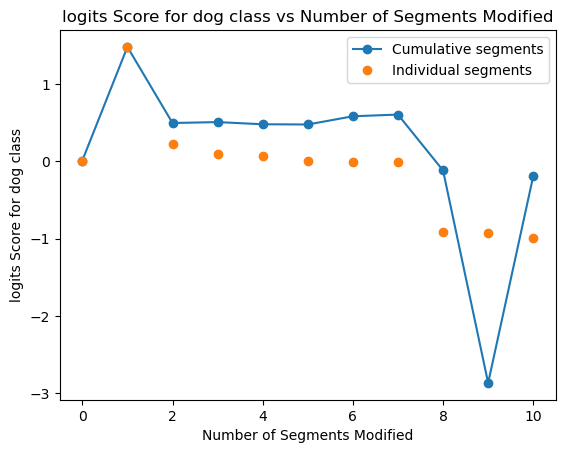

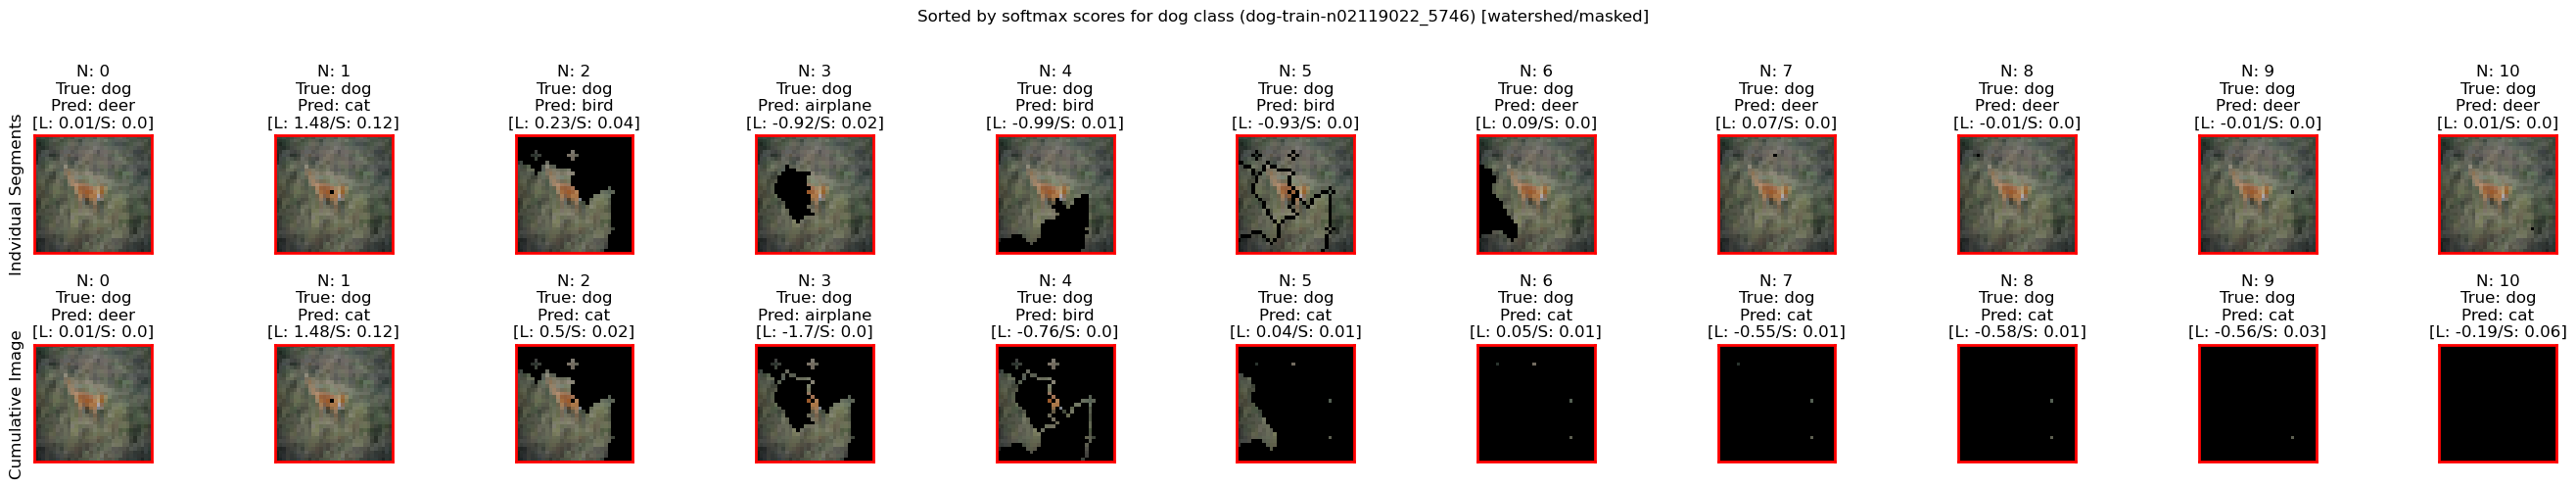

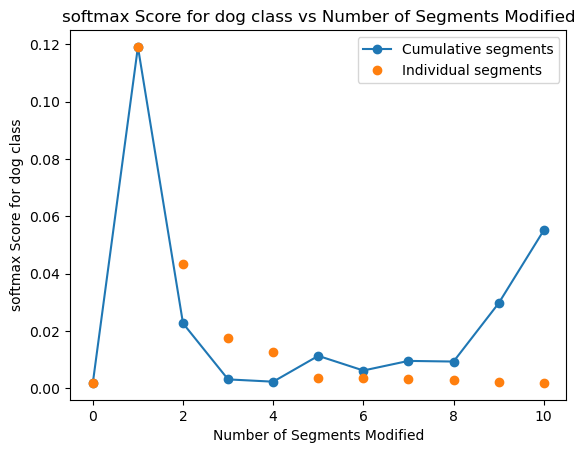

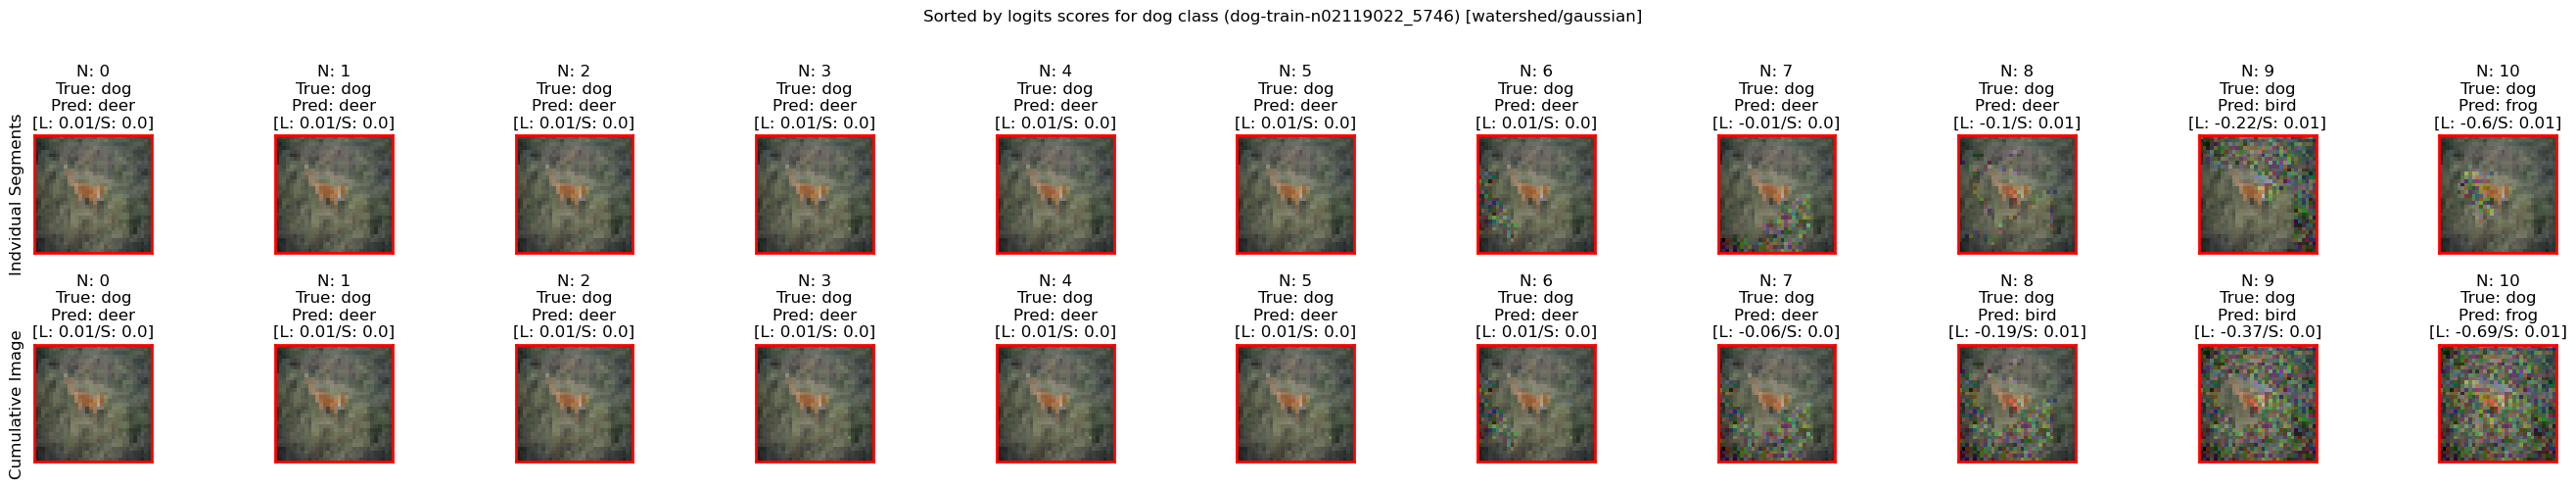

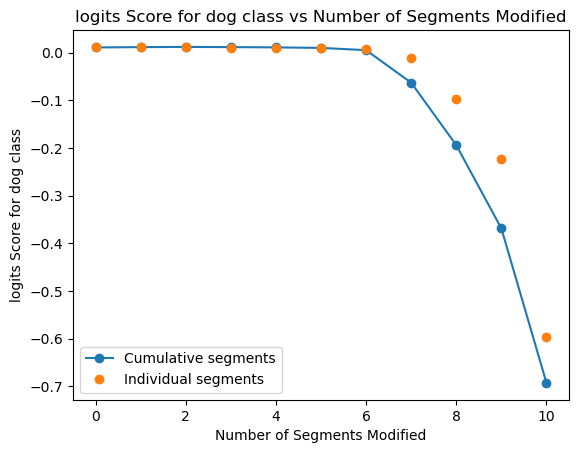

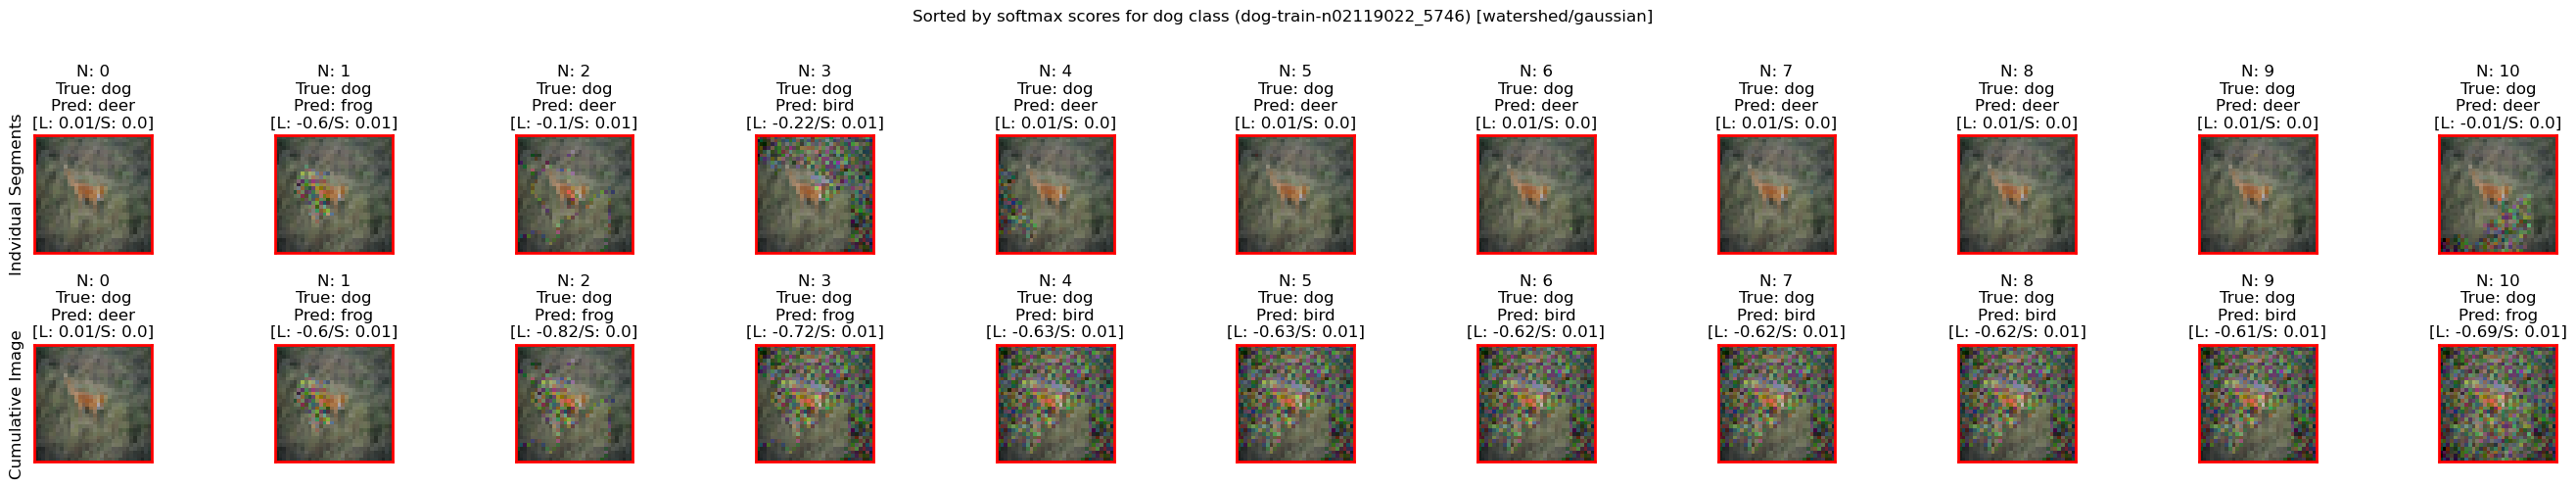

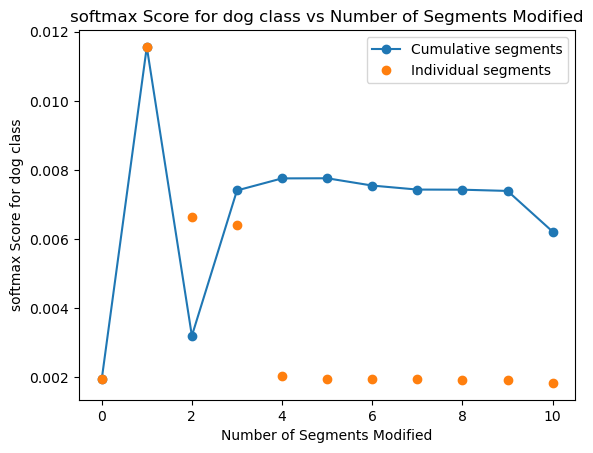

done


In [49]:
image_path = key_images[0]
print(image_path)
image = load_image(image_path, data_format='CHW')
image_id = get_image_id(image_path)
class_idx = class_to_idx_dict[target_class]
image_save_dir = os.path.join(save_dir_root, image_id)

informal_log("Target idx: {}".format(class_idx), log_path)
informal_log('Image save directory: {}'.format(image_save_dir), log_path)

segment_semantically(
        image=image,
        image_id=image_id,
        methods_params=methods,
        model=model,
        device=device,
        target_idx=class_idx,
        seed=seed,
        save_dir=image_save_dir,
        debug=debug)
print("done")

In [ ]:
class_idx = class_to_idx_dict[target_class]
key_paths_logits = []
key_paths_softmax = []
key_paths_failures = []
value_paths_logits = []
value_paths_softmax = []
value_paths_failures = []

for idx, image_path in enumerate(key_images):
    informal_log("[{}] Trial {}/{} with image {}...".format(
        datetime.now().strftime(r'%m%d_%H%M%S'),
        idx+1,
        len(key_images),
        image_path), log_path)
    
    # Load image, get ID, create save directory
    image = load_image(image_path, data_format='CHW')
    image_id = get_image_id(image_path)
    image_save_dir = os.path.join(save_dir_root, image_id)
    
    # Run semantic segmentation-modification method
    logit_save_image_paths, \
        softmax_save_image_paths, \
        unsucessful_edit_save_paths = segment_semantically(
            image=image,
            image_id=image_id,
            methods_params=methods,
            model=model,
            device=device,
            target_idx=class_idx,
            seed=seed,
            save_dir=image_save_dir,
            debug=debug)
    
    informal_log("[{}] Saved results to {}".format(datetime.now().strftime(r'%m%d_%H%M%S'), image_save_dir), 
         log_path)
    
    # Create correct number of key paths
    key_paths_l = [image_path for i in range(len(logit_save_image_paths))]
    key_paths_s = [image_path for i in range(len(softmax_save_image_paths))]
    key_paths_f = [image_path for i in range(len(unsucessful_edit_save_paths))]
    
    # Append to key paths lists
    key_paths_logits += key_paths_l
    key_paths_softmax += key_paths_s
    key_paths_failures += key_paths_f
    
    # Append to value paths lists
    value_paths_logits += logit_save_image_paths
    value_paths_softmax += softmax_save_image_paths
    value_paths_failures += unsucessful_edit_save_paths
    

In [41]:
# Save paths
write_lists(os.path.join(path_save_dir, 'key_images_logits.txt'), key_paths_logits)
write_lists(os.path.join(path_save_dir, 'key_images_softmax.txt'), key_paths_softmax)
write_lists(os.path.join(path_save_dir, 'key_images_failures.txt'), key_paths_failures)

write_lists(os.path.join(path_save_dir, 'value_images_logits.txt'), value_paths_logits)
write_lists(os.path.join(path_save_dir, 'value_images_softmax.txt'), value_paths_softmax)
write_lists(os.path.join(path_save_dir, 'value_images_failures.txt'), value_paths_failures)

print("Wrote paths to {}".format(path_save_dir))
            

Wrote paths to paths/edits/semantics/cat/0124_142942


# FIN


## Load and visualize a group of edit image pairs

<class 'list'>
[('data/cinic-10-imagenet/train/cat/n02123394_4630.png', 'saved/segmentations/semantics/cat_20/cat-train-n02123394_4630/quickshift_masked/quickshift_masked_logits.png'), ('data/cinic-10-imagenet/train/cat/n02121808_843.png', 'saved/segmentations/semantics/cat_20/cat-train-n02121808_843/slic_masked/slic_masked_logits.png')]


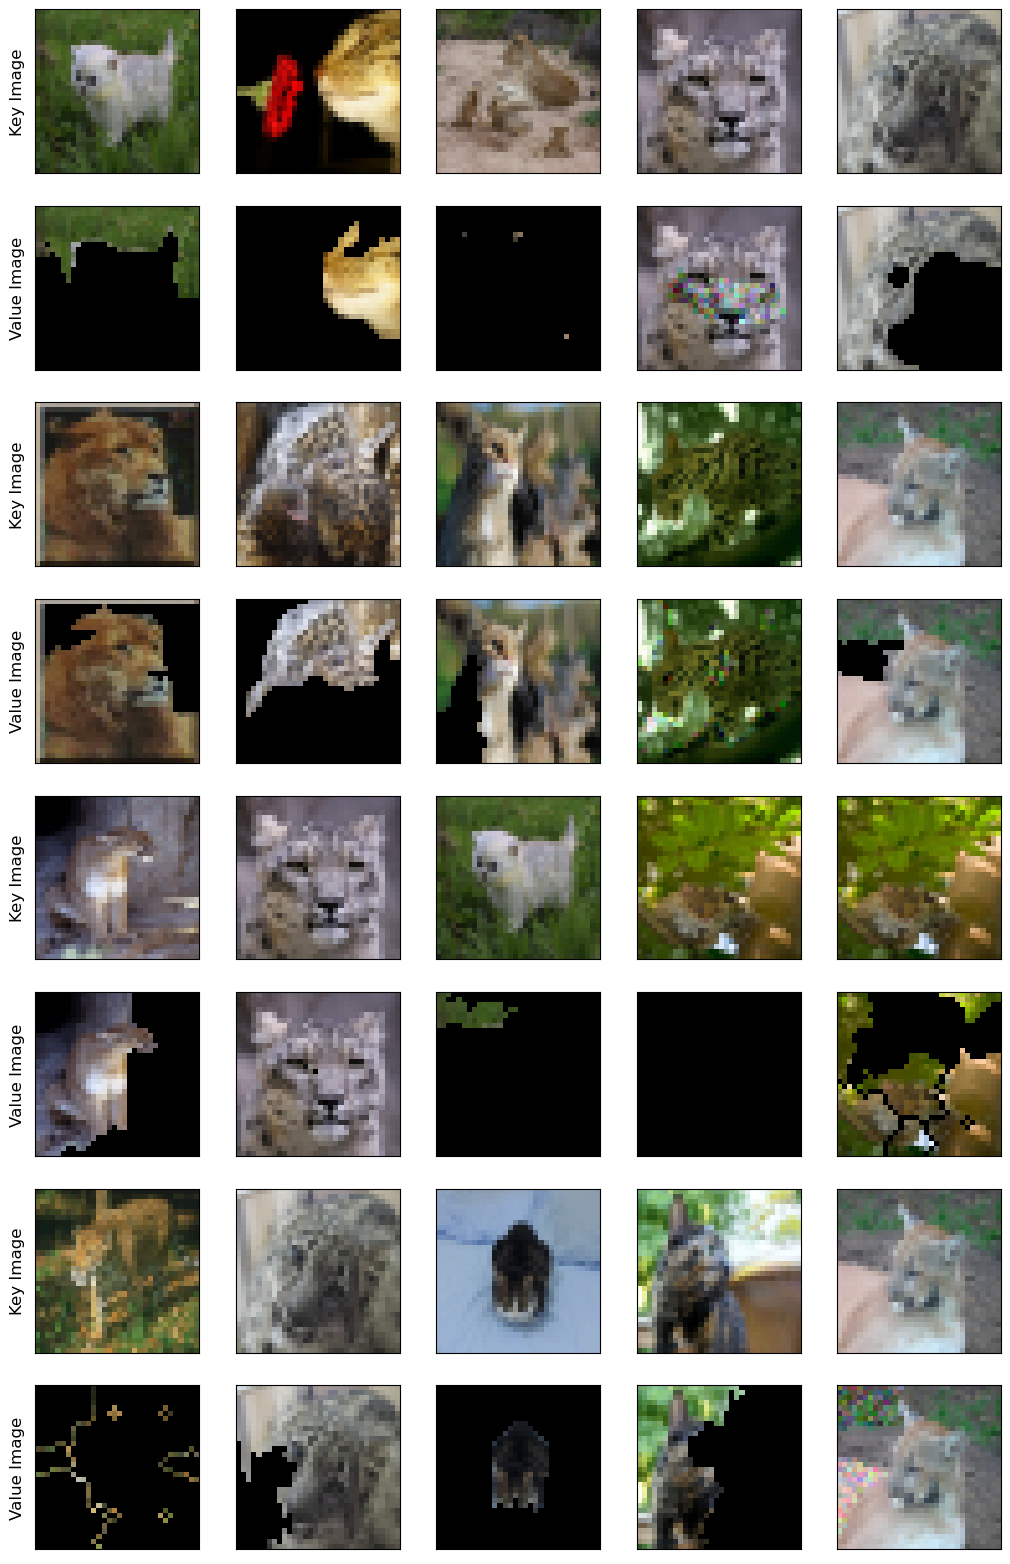

In [27]:
target_class = 'cat'
timestamp = '0120_144821'
sort_type = 'logits'
n_display = 20
n_per_row = 5
paths_root_dir = os.path.join('paths', 'edits', 'semantics', target_class, timestamp)
random.seed(seed)

key_image_paths_path = os.path.join(paths_root_dir, 'key_images_{}.txt'.format(sort_type))
value_image_paths_path = os.path.join(paths_root_dir, 'value_images_{}.txt'.format(sort_type))

key_image_paths = read_lists(key_image_paths_path)
value_image_paths = read_lists(value_image_paths_path)

zipped_paths = list(zip(key_image_paths, value_image_paths))
print(type(zipped_paths))
random.shuffle(zipped_paths)
print(zipped_paths[:2])

key_images = []
value_images = []
for idx, (key_image_path, value_image_path) in enumerate(zipped_paths): #enumerate(zip(key_image_paths, value_image_paths)):
    if idx == n_display:
        break
    key_image = load_image(key_image_path, data_format='HWC')
    value_image = load_image(value_image_path, data_format='HWC')
    
    key_images.append(key_image)
    value_images.append(value_image)
    
# Make both into grid
key_images = make_grid(flattened=key_images, items_per_row=n_per_row)
value_images = make_grid(flattened=value_images, items_per_row=n_per_row)
n_rows = len(key_images)

assert len(value_images) == n_rows
# Intersperse them
master_grid = []
labels = []
for row_idx in range(n_rows):
    master_grid.append(key_images[row_idx])
    labels.append('Key Image')
    master_grid.append(value_images[row_idx])
    labels.append('Value Image')
    
show_image_rows(
    images=master_grid,
    row_labels=labels,
    save_path=os.path.join('temp', "key_val_side_by_side.png"))
    

In [22]:
print(value_image_paths[0])
save_dir = 

SyntaxError: invalid syntax (3623869496.py, line 2)